# **MÔI TRƯỜNG LẬP TRÌNH**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import time
import warnings
from collections import Counter
import mlxtend
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
path = ''
data = pd.read_excel(path + 'Market Basket Analysis 5.xlsx', header = None, sheet_name = 'Sheet1')
data.columns = ['Date', 'Basket']
data.head()

,Date,Basket
0,1/1/2000,"yogurt, pork, sandwich bags, lunch meat, all- ..."
1,1/1/2000,"toilet paper, shampoo, hand soap, waffles, veg..."
2,2/1/2000,"soda, pork, soap, ice cream, toilet paper, din..."
3,2/1/2000,"cereals, juice, lunch meat, soda, toilet paper..."
4,2/1/2000,"sandwich loaves, pasta, tortillas, mixes, hand..."


# ECLAT

In [46]:
class Eclat:
    """
    ECLAT (Equivalence Class Clustering and bottom-up Lattice Traversal) Algorithm.

    The ECLAT algorithm is used to find frequent itemsets in transactional data
    using a vertical representation (item-to-transaction mapping). It also supports
    the generation of association rules.

    Parameters:
        min_support (float): The minimum support threshold for itemsets (default: 0.01).
        verbose (bool): If True, print progress and details during execution (default: False).

    Attributes:
        itemsets (list): List of frequent itemsets with their transaction IDs.
        item_support (dict): Support values for each frequent itemset.
        transaction_count (int): Total number of transactions.
    """

    def __init__(self, min_support=0.01, verbose=False):
        self.min_support = min_support
        self.verbose = verbose
        self.itemsets = []
        self.item_support = {}
        self.transaction_count = 0

    def fit(self, transactions):
        """
        Fit the model to transactional data.

        Args:
            transactions (list of list): A list of transactions, where each transaction
                                         is a list of items.

        Returns:
            self: The fitted ECLAT model.
        """
        self.transaction_count = len(transactions)
        vertical_db = defaultdict(set)
        # Chuyển đổi dữ liệu thanh vertical database
        for tid, transaction in enumerate(transactions):
            unique_items = set(transaction)
            for item in unique_items:
                vertical_db[item].add(tid)

        if self.verbose:
            print(f"Initial vertical database size: {len(vertical_db)} items")
        # Tìm kiếm tập phổ biến
        self.itemsets = self._mine(vertical_db, min_length=1)
        # Tính support
        self.item_support = {
            itemset: len(tids) / self.transaction_count
            for itemset, tids in self.itemsets.items()
        }

        return self

    def _mine(self, vertical_db, prefix=set(), min_length=1):
        """
        Recursively mine frequent itemsets.

        Args:
            vertical_db (dict): Vertical database mapping items to transaction IDs.
            prefix (set): Current prefix of items.
            min_length (int): Minimum length of itemsets to consider.

        Returns:
            dict: Frequent itemsets with their transaction IDs.
        """
        frequent_itemsets = {}
        # Duyệt qua từng item
        for item, tids in vertical_db.items():
            new_itemset = prefix | {item}
            support = len(tids) / self.transaction_count

            if support >= self.min_support: # Kiểm tra thỏa minSup
                frequent_itemsets[frozenset(new_itemset)] = tids
                # Intersect các tID mới
                new_vertical_db = {
                    other_item: other_tids & tids
                    for other_item, other_tids in vertical_db.items()
                    if other_item > item
                }

                frequent_itemsets.update(self._mine(new_vertical_db, new_itemset, min_length))

        return frequent_itemsets

    def get_frequent_itemsets(self):
        """
        Get the frequent itemsets and their support values.

        Returns:
            dict: Frequent itemsets (frozenset) and their support values.
        """
        return {
            frozenset(itemset): support
            for itemset, support in self.item_support.items()
        }

    def generate_rules(self, min_confidence=0.5):
        """
        Generate association rules from frequent itemsets, including Lift.

        Args:
            min_confidence (float): Minimum confidence threshold for rules.

        Returns:
            list: List of association rules, each represented as a dictionary with keys:
                  'antecedent', 'consequence', 'confidence', 'support', and 'lift'.
        """
        rules = []
        for itemset in self.item_support.keys():
            if len(itemset) > 1:
                for consequence in itemset:
                    antecedent = itemset - {consequence}
                    confidence = self.item_support[itemset] / self.item_support[antecedent]

                    if confidence >= min_confidence:
                        lift = confidence / self.item_support[frozenset({consequence})]
                        rules.append({
                            "antecedent": set(antecedent),
                            "consequence": {consequence},
                            "confidence": confidence,
                            "support": self.item_support[itemset],
                            "lift": lift
                        })
        return rules

In [45]:
# Hàm chuyển đổi các dạng kết quả thành dataframe
def convert_to_dataframe(frequent_itemsets):
    data = [
        {
            "itemsets": set(itemset),
            "support": support,
            "frequency": round(support * transaction_count)
        }
        for itemset, support in frequent_itemsets.items()
    ]

    return pd.DataFrame(data)
def rules_to_dataframe(rules):
    return pd.DataFrame([
        {
            "Antecedent": rule["antecedent"],
            "Consequence": rule["consequence"],
            "Confidence": rule["confidence"],
            "Support": rule["support"],
            "Lift": rule["lift"]
        }
        for rule in rules
    ])

In [44]:
# Áp dụng ECLAT
transactions = data['Basket'].tolist()
transactions = [transaction.split(", ") for transaction in transactions]
transactions = [[item.strip().lower().rstrip(',') for item in transaction] for transaction in transactions]
transaction_count = len(transactions)
print(f"Total number of transactions: {transaction_count}")
eclat = Eclat(min_support=0.1, verbose=True)
eclat.fit(transactions)
frequent_itemsets = eclat.get_frequent_itemsets()
rules = eclat.generate_rules(min_confidence=0.8)

Total number of transactions: 1499
Initial vertical database size: 38 items


In [38]:
eclat_res = convert_to_dataframe(frequent_itemsets)
eclat_res.sort_values(by='support', ascending=False, inplace=True)

In [39]:
eclat_res[['itemsets', 'support']]

,itemsets,support
505,{vegetables},0.726484
1037,{poultry},0.408939
931,{waffles},0.391594
797,{dishwashing liquid/detergent},0.390260
58,{ice cream},0.389593
...,...,...
67,"{vegetables, ice cream, pork}",0.103402
1358,"{vegetables, fruits, pork}",0.102068
1234,"{vegetables, pork, pasta}",0.101401
537,"{vegetables, beef, butter}",0.101401


In [40]:
print("Association Rules:")
for rule in rules[:100]:
    print(f"{rule['antecedent']} -> {rule['consequence']} (Conf: {rule['confidence']:.2f}, Supp: {rule['support']:.2f}, Lift: {rule['lift']:.2f})")

Association Rules:
{'dinner rolls', 'ice cream'} -> {'vegetables'} (Conf: 0.82, Supp: 0.13, Lift: 1.14)
{'dinner rolls', 'flour'} -> {'vegetables'} (Conf: 0.81, Supp: 0.12, Lift: 1.12)
{'dinner rolls', 'shampoo'} -> {'vegetables'} (Conf: 0.80, Supp: 0.13, Lift: 1.10)
{'lunch meat', 'dinner rolls'} -> {'vegetables'} (Conf: 0.82, Supp: 0.13, Lift: 1.13)
{'dinner rolls', 'laundry detergent'} -> {'vegetables'} (Conf: 0.85, Supp: 0.14, Lift: 1.18)
{'dinner rolls', 'mixes'} -> {'vegetables'} (Conf: 0.81, Supp: 0.13, Lift: 1.11)
{'dinner rolls', 'soda'} -> {'vegetables'} (Conf: 0.83, Supp: 0.14, Lift: 1.15)
{'dinner rolls', 'sandwich bags'} -> {'vegetables'} (Conf: 0.83, Supp: 0.12, Lift: 1.15)
{'dinner rolls', 'soap'} -> {'vegetables'} (Conf: 0.81, Supp: 0.12, Lift: 1.11)
{'yogurt', 'dinner rolls'} -> {'vegetables'} (Conf: 0.84, Supp: 0.13, Lift: 1.15)
{'dinner rolls', 'waffles'} -> {'vegetables'} (Conf: 0.84, Supp: 0.14, Lift: 1.16)
{'hand soap', 'dinner rolls'} -> {'vegetables'} (Conf: 0.8

# APRIORI

In [ ]:
df = data.copy()

In [43]:
df.drop(['Date'], axis=1, inplace=True)
# Định dạng lại dữ liệu đầu vào cho phù hợp với thư viện mlxtend
df['Basket'] = df['Basket'].str.split(',').apply(
    lambda x: [item.strip().lower().rstrip(',') for item in x if item.strip()]
)
# Chỉ lấy sự xuất hiện đầu tiên trong giỏ hàng
all_products = set(product for basket in df['Basket'] for product in basket if product)

for product in all_products:
    df[product] = df['Basket'].apply(lambda basket: True if product in basket else False)

df.drop(columns=['Basket'], inplace=True)

print(df)

KeyError: "['Date'] not found in axis"

In [27]:
ap = apriori(df, min_support=0.2, use_colnames=True)
ap.sort_values(by='support', ascending=False, inplace=True)

In [28]:
ap

,support,itemsets
35,0.726484,(vegetables)
16,0.408939,(poultry)
21,0.391594,(waffles)
31,0.390260,(dishwashing liquid/detergent)
0,0.389593,(ice cream)
...,...,...
43,0.275517,"(tortillas, vegetables)"
70,0.272849,"(vegetables, ketchup)"
39,0.270847,"(vegetables, flour)"
57,0.267512,"(pork, vegetables)"


In [29]:
ap_rules = association_rules(ap, num_itemsets=df.shape[0], metric="confidence", min_threshold=0.8)
ap_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(eggs),(vegetables),0.381588,0.726484,0.310874,0.814685,1.121408,1.0,0.033656,1.475953,0.175067,0.389958,0.322471,0.621300
1,(aluminum foil),(vegetables),0.386258,0.726484,0.309540,0.801382,1.103096,1.0,0.028930,1.377092,0.152279,0.385382,0.273832,0.613730
2,(yogurt),(vegetables),0.378252,0.726484,0.308205,0.814815,1.121586,1.0,0.033411,1.476985,0.174356,0.386935,0.322945,0.619529
3,(laundry detergent),(vegetables),0.375584,0.726484,0.304203,0.809947,1.114885,1.0,0.031347,1.439153,0.165029,0.381271,0.305147,0.614340
4,(sugar),(vegetables),0.366911,0.726484,0.293529,0.800000,1.101194,1.0,0.026974,1.367578,0.145153,0.366972,0.268780,0.602020


In [30]:
ap_rules.shape

(5, 14)

# FP-GROWTH

In [31]:
fp = fpgrowth(df, min_support=0.1, use_colnames=True)

In [32]:
fp

,support,itemsets
0,0.726484,(vegetables)
1,0.389593,(ice cream)
2,0.388259,(lunch meat)
3,0.386258,(soda)
4,0.386258,(aluminum foil)
...,...,...
1402,0.121414,"(spaghetti sauce, vegetables, sugar)"
1403,0.122081,"(vegetables, sugar, all- purpose)"
1404,0.126084,"(aluminum foil, vegetables, sugar)"
1405,0.130754,"(cereals, vegetables, sugar)"


# EVALUATION

In [42]:
transactions = data['Basket'].tolist()
transactions = [transaction.split(", ") for transaction in transactions]
transactions = [[item.strip().lower().rstrip(',') for item in transaction] for transaction in transactions]

# Tạo khoảng support
min_support_values = np.linspace(0.1, 0.5, 5)

results = {'FP-Growth': [], 'Apriori': [], 'ECLAT': []}

num_runs = 10

for min_support in min_support_values:
    fp_time_list = []
    apriori_time_list = []
    eclat_time_list = []

    for _ in range(num_runs):
        # FP-Growth
        start_time = time.time()
        fpgrowth(df, min_support=min_support, use_colnames=True)
        fp_time_list.append(time.time() - start_time)

        # Apriori
        start_time = time.time()
        apriori(df, min_support=min_support, use_colnames=True)
        apriori_time_list.append(time.time() - start_time)

        # ECLAT
        start_time = time.time()
        eclat = Eclat(min_support=min_support)
        eclat.fit(transactions)
        eclat_time_list.append(time.time() - start_time)

    results['FP-Growth'].append(np.mean(fp_time_list))
    results['Apriori'].append(np.mean(apriori_time_list))
    results['ECLAT'].append(np.mean(eclat_time_list))

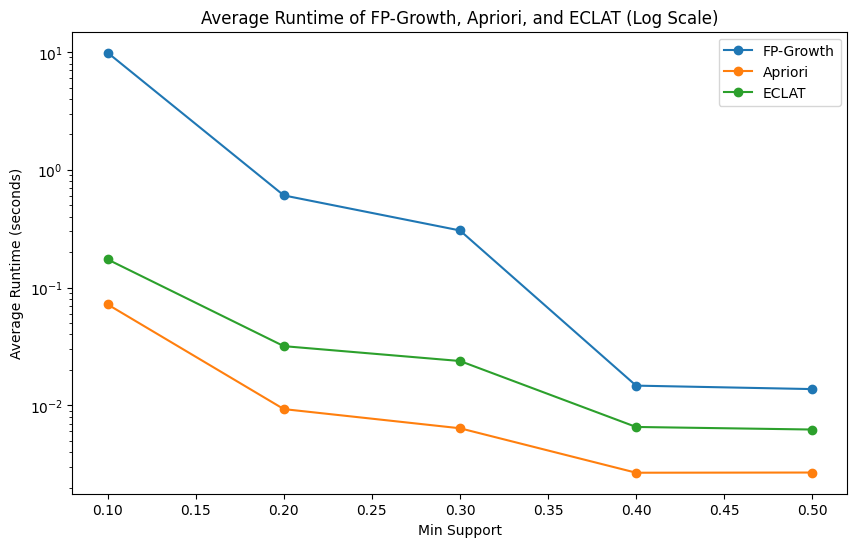

In [41]:
plt.figure(figsize=(10, 6))
for algo, times in results.items():
    plt.plot(min_support_values, times, marker='o', label=algo)

plt.yscale('log') # Chuyển thang đo sang Log để nhìn rõ sự sai khác giữa thời gian nhỏ
plt.title('Average Runtime of FP-Growth, Apriori, and ECLAT (Log Scale)')
plt.xlabel('Min Support')
plt.ylabel('Average Runtime (seconds)')
plt.legend()
plt.show()